In [ ]:
pip install torch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.9 MB/s eta 0:00:00


In [2]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import os
import torch
# import torch_optimizer as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from collections import defaultdict
from tqdm import tqdm
import time
from IPython.display import Image, clear_output

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

# DATA PREPROCES

In [5]:
X_path ='/content/drive/MyDrive/infa project/foot/X_9_RGB.pickle'
y_path = '/content/drive/MyDrive/infa project/foot/y_9_RGB.pickle'

In [6]:
X = pd.read_pickle(X_path)
y = pd.read_pickle(y_path)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [11]:
X_train.shape,X_val.shape,X_test.shape

((1440, 224, 224, 3), (180, 224, 224, 3), (181, 224, 224, 3))

In [13]:
X_train[200].shape

(224, 224, 3)

In [9]:
arr = y_train
unique, counts = np.unique(arr, return_counts=True)

for i in range(len(unique)):
    print("Класс", unique[i], "встречается в массиве с долей", counts[i]/len(arr))

NameError: ignored

In [ ]:
classes = {
    0: 'Normal foot',
    1: 'Left foot forward leaned',
    2: 'Right foot forward leaned',
    3: 'Left foot backward leaned',
    4: 'Right foot backward leaned',
    5: 'Left sided lean',
    6: 'Right sided lean',
    7: 'Left foot twisted',
    8: 'Right foot twisted',
}

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class Foot(Dataset):
      def __init__(self, data,target, transform=None):
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)
        self.transform = transform
      def __len__(self):
        return len(self.data)
      def __getitem__(self, idx):
        if torch.is_tensor(idx):
              idx = idx.tolist()
        x = self.data[idx]
        y = self.target[idx]
        x = x.permute(2,0,1)
        if self.transform:
            x = self.transform(x)
        return x, y

In [ ]:
BATCH_SIZE = 32
train_data = Foot(X_train,y_train,transform)
val = Foot(X_val, y_val,transform)
test = Foot(X_test, y_test,transform)

train_loader = DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val,batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test,batch_size=BATCH_SIZE)

In [ ]:
next(iter(val_loader))[0].shape,next(iter(test_loader))[0].shape,

(torch.Size([32, 3, 224, 224]), torch.Size([32, 3, 224, 224]))

In [ ]:
# for image, label in val_loader:
#   print(image.shape, label.shape)


In [ ]:
for i in range(3):
  image ,label = val[i][0], val[i][1]
  plt.title(classes[int(label)])
  plt.imshow(image.permute(1,2,0))
  plt.show()

# MODEL


In [ ]:
from torchvision.models import resnet34,resnet50
model = resnet50(pretrained=True).to(device)


In [ ]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 9),
)

In [ ]:
model

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Ranger(model.parameters(), lr=1e-4)

# testing

In [ ]:
test = torch.randn((16, 3, 224, 224))
logit = model(test)


In [ ]:
label = next(iter(train_loader))[1]
logit.shape,label.view(-1, 1).float().shape

(torch.Size([16, 9]), torch.Size([16, 1]))

In [ ]:
criterion(logit,label.long().to(device))


tensor(2.1902, grad_fn=<NllLossBackward0>)

# FUNCIONS

In [ ]:
def plot_learning_curves(history):
    fig = plt.figure(figsize=(20, 7))
    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.subplot(1,2,2)
    plt.title('f1', fontsize=15)
    plt.plot(history['f1']['train'], label='train')
    plt.plot(history['f1']['val'], label='val')
    plt.ylabel('f1', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(model,criterion, optimizer, train_loader, val_loader,  num_epochs, checkpoints_dir=None, scheduler=None,train_aug=None, val_aug=None):
    history = defaultdict(lambda: defaultdict(list))
    device = "cuda" if torch.cuda.is_available() else 'cpu'
    print(device)
    model = model.to(device)
    all_time = 0
    best_f1_macro = 0.0
    for epoch in range(num_epochs):
        train_loss = 0
        train_f1 = 0
        train_for_f1_b = []
        train_for_f1_p = []
        val_loss = 0
        val_f1 = 0
        val_for_f1_b = []
        val_for_f1_p = []
        start_time = time.time()
        model.train()
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            if train_aug:
                images = train_aug(images)
            logits = model(images)
            loss = criterion(logits, labels.long().to(device))
            loss.backward()
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()

            train_for_f1_b = np.append(train_for_f1_b, labels.cpu().numpy())
            train_for_f1_p = np.append(train_for_f1_p, y_pred)
            optimizer.step()
            optimizer.zero_grad()

        train_loss /= len(train_loader)
        train_f1 = f1_score(train_for_f1_b, train_for_f1_p, average="macro")
        history['loss']['train'].append(train_loss)
        history['f1']['train'].append(train_f1)
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images = images.to(device)
                labels = labels.to(device)
                if val_aug:
                    images = val_aug(images)
                logits = model(images)

                loss1 = criterion(logits, labels.long().to(device))

                val_loss += loss1.detach().cpu().numpy()
                y_pred = logits.max(1)[1].detach().cpu().numpy()
                val_for_f1_b = np.append(val_for_f1_b, labels.cpu().numpy())
                val_for_f1_p = np.append(val_for_f1_p, y_pred)

        val_loss /= len(val_loader)
        val_f1 = f1_score(val_for_f1_b, val_for_f1_p, average="macro")
        history['loss']['val'].append(val_loss)
        history['f1']['val'].append(val_f1)
        clear_output()
        # Сохраняем лучшую модель по метрике F1-macro
        if checkpoints_dir and val_f1 > best_f1_macro:
            os.makedirs(checkpoints_dir, exist_ok=True)
            best_f1_macro = val_f1
            path = os.path.join(checkpoints_dir, 'best.checkpoint')
            torch.save(model.state_dict(), path)
        # Обновляем learning rate
        if scheduler:
            scheduler.step(val_loss)
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print(" training loss (in-iteration): \t{:.6f}".format(train_loss))
        print(" validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print(" training f1: \t\t\t{:.2f} %".format(train_f1 * 100))
        print(" validation f1: \t\t\t{:.2f} %".format(val_f1 * 100))
        plot_learning_curves(history)
        all_time += (time.time() - start_time)
    return model, history, all_time



# training

Epoch 10 of 10 took 18.328s
 training loss (in-iteration): 	0.022246
 validation loss (in-iteration): 	0.067041
 training f1: 			99.65 %
 validation f1: 			97.60 %


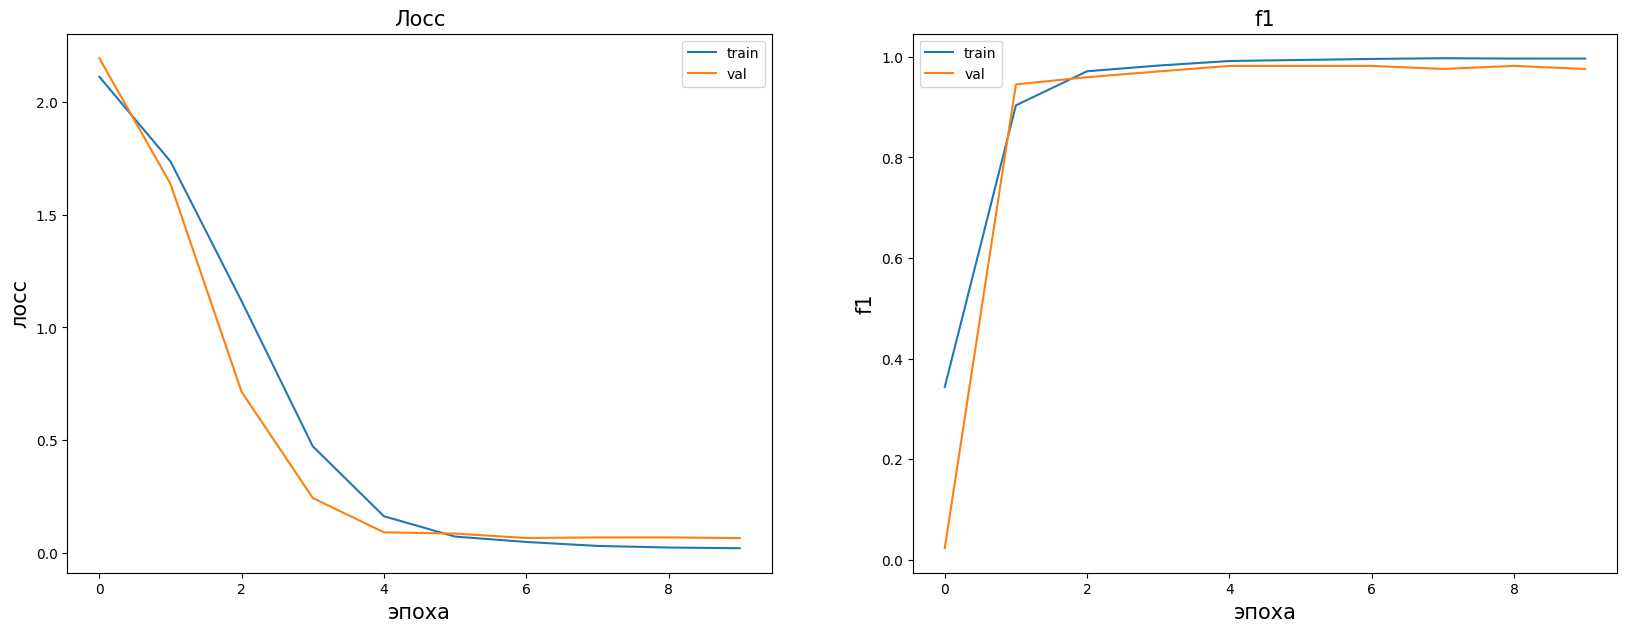

In [ ]:
model, history, all_time = train(
    model, criterion, optimizer,
    train_loader, val_loader,
    num_epochs=10)

In [ ]:
model.state_dict()

In [ ]:
chek = '/content/drive/MyDrive/infa project/foot'
path = os.path.join(chek, 'best$.checkpoint')
torch.save(model.state_dict(), path)

In [ ]:
state_dict = torch.load(path)

In [ ]:
test = resnet50().to(device)
test.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 9),
)

In [ ]:
test.load_state_dict(state_dict)

<All keys matched successfully>

modal test (after interapting)

In [ ]:
y_b = []
y_p = []
for X_batch, y_batch in test_loader:
    y_b = np.append(y_b, y_batch.cpu().numpy())
    y_p = np.append(y_p, model(X_batch.to(device)).max(1)[1].detach().cpu().numpy())

In [ ]:
test_f1_score = f1_score(y_b, y_p, average="macro")

test_f1_score

0.9782551560728608

loaded modal test

In [ ]:
y_b = []
y_p = []
for X_batch, y_batch in test_loader:
    y_b = np.append(y_b, y_batch.cpu().numpy())
    y_p = np.append(y_p, test(X_batch.to(device)).max(1)[1].detach().cpu().numpy())

In [ ]:
test_f1_score = f1_score(y_b, y_p, average="macro")

test_f1_score

Testing efficientnet


In [ ]:
from torchvision.models import efficientnet_b7

In [ ]:
model = efficientnet_b7(pretrained=True)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Ranger(model.parameters(), lr=1e-4)

Epoch 10 of 10 took 18.205s
 training loss (in-iteration): 	0.010989
 validation loss (in-iteration): 	0.115165
 training f1: 			99.72 %
 validation f1: 			97.60 %


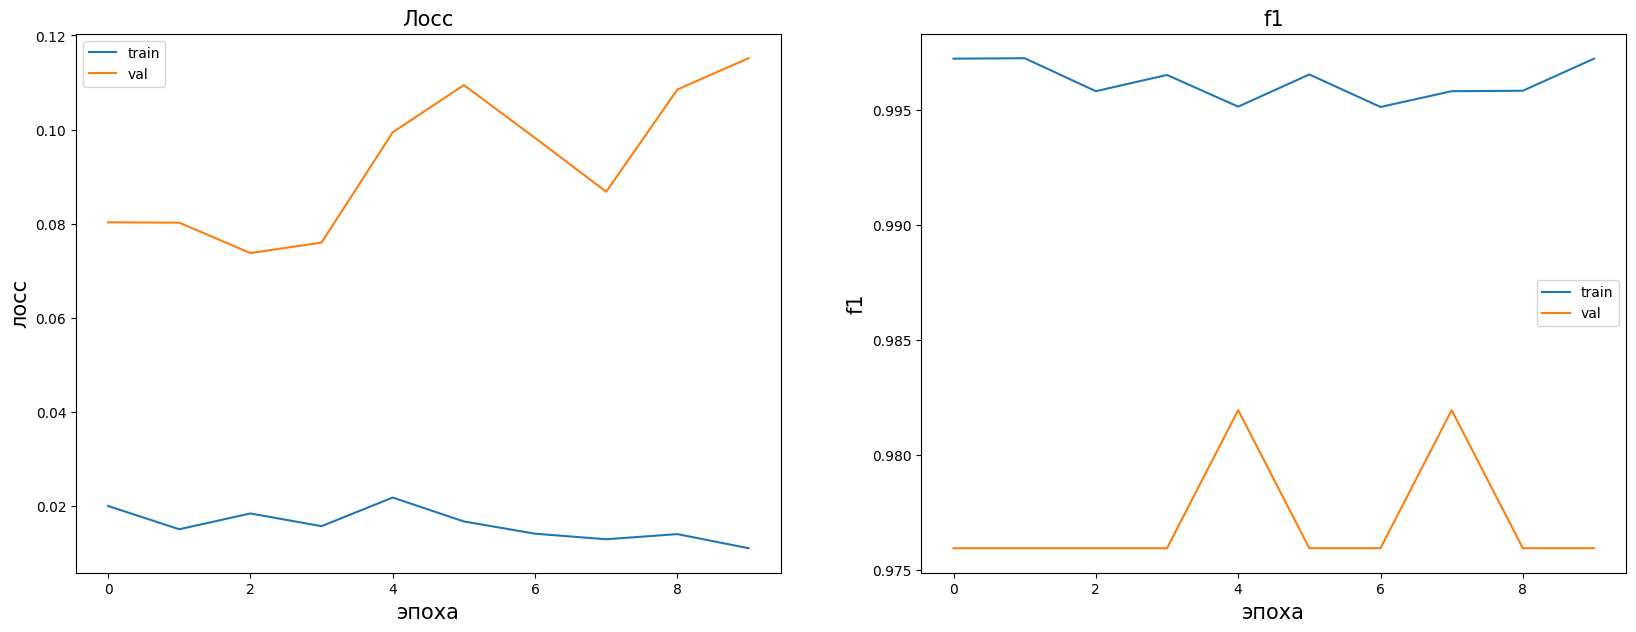

In [ ]:
model, history, all_time = train(
    model, criterion, optimizer,
    train_loader, val_loader,
    num_epochs=10)

In [ ]:
y_b = []
y_p = []
for X_batch, y_batch in test_loader:
    y_b = np.append(y_b, y_batch.cpu().numpy())
    y_p = np.append(y_p, model(X_batch.to(device)).max(1)[1].detach().cpu().numpy())

In [ ]:
test_f1_score = f1_score(y_b, y_p, average="macro")

test_f1_score

0.9788490376725671